In [1]:
cd ~/microbiome_rnn/

/Volumes/export/isn/mwiest/microbiome_rnn


In [2]:
from __future__ import print_function
%matplotlib inline
import os
import torch
import numpy as np
import sys
from otu_handler import OTUHandler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from models.rnn.conv_lstm import *
from models.rnn.lstm import *
from models.enc_dec.encoder_decoder import *
from models.ffn.ffn import *
from models.ffn.conv_ffn import *
from helpers.model_helper import *

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [3]:
# Some helper functions.

def get_primer_and_comparison_data(otu_handler,
                                   sample_index,
                                   start_index,
                                   primer_len,
                                   predict_len):
    primer = otu_handler.samples[sample_index].values[:, start_index: start_index + primer_len]
    # Need to make it 3d because the last dimension is how many predictions to do at once. 
    primer = np.expand_dims(primer, -1)
    # Get the comparison data.
    comparison = otu_handler.samples[sample_index].values[:, start_index:predict_len + start_index + primer_len]
    return primer, comparison

def complete_and_multiindex_df(df, split_char):
    default_tax = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    s = list(df.index.values)
    lt = [list(ls.split(split_char)) for ls in s]
    lt = [[ltii.strip() for ltii in lti] for lti in lt]
    for l in lt:
        if len(l) < len(default_tax):
            l += default_tax[-(len(default_tax)-len(l)):]

    ltn = pd.DataFrame(np.array(lt))
    ltn.index = df.index
    ltn.columns = default_tax
    combined = pd.concat((df, ltn), axis=1)
    combined.set_index(default_tax, inplace=True)
    return combined

In [4]:
# This is just a nice label for the plotting
file_labs = ['Donor$_0$', 'Donor$_1$', 'Donor$_{2, 0}$', 'Donor$_{2, 1}$', 'Donor$_3$']

In [5]:
# Put the model type in here
model_type = 'enc_dec'
# What is the name of the model and logs outputted?
run_suffix = '_EncDec_h512_sl5_rns62_sif2_stacked_lstm'

In [6]:


model_lookup = {
    'enc_dec': EncoderDecoder,
    'lstm': LSTM,
    'conv_lstm': ConvLSTM,
    'ffn': FFN,
    'conv_ffn': ConvFFN
}

model_outputs = {
    'enc_dec': 'enc_dec_output/',
    'lstm': 'rnn_output/',
    'ffn': 'ffn_output',
    'conv_ffn': 'ffn_output',
    'conv_lstm': 'rnn_output'
}

In [7]:
model_name = 'model{}.pt'.format(run_suffix)
log_name = 'log{}.csv'.format(run_suffix)
output_dir = model_outputs[model_type]


# Plot the Training Loss

In [8]:
losses = np.loadtxt(os.path.join(output_dir, log_name), delimiter=',')


Text(0.5,1,'Loss Over Training')

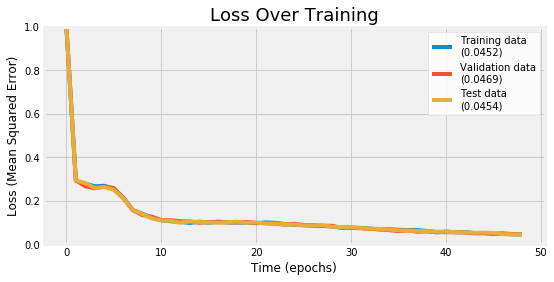

In [9]:
loss_num_digits = 6

plt.figure(figsize=(8, 4))
plt.plot(losses[0, :].T, label='Training data\n({})'.format(str(losses[0, -1])[:loss_num_digits]))
plt.plot(losses[1, :].T, label='Validation data\n({})'.format(str(losses[1, -1])[:loss_num_digits]))
if losses.shape[0] == 3:
    plt.plot(losses[2, :].T, label='Test data\n({})'.format(str(losses[2, -1])[:loss_num_digits]))
legend = plt.legend(frameon = 1, loc='upper right')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.xlabel('Time (epochs)')
plt.ylabel('Loss (Mean Squared Error)')
plt.ylim(0, 1)
plt.title('Loss Over Training', fontsize=18)


# Model "Dreaming" Analysis

In [10]:
# What data to load to the data handler.
input_dir = 'all_studies_reduced_62/'
test_dir = 'all_studies_reduced_62_test/'


In [11]:
# Instantiate an OTU Handler.



input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

# Uncomment this if you want to include the test data in the plots:
input_files += test_files

otu_handler = OTUHandler(input_files)
otu_handler.normalize_data()

In [12]:
# Instantiate the model
hidden_dim = 512
reduced_num_strains = 62
slice_len = 62
use_gpu = torch.cuda.is_available()


# Basically load the correct type of model. 
if model_type == 'enc_dec' or model_type.endswith('lstm'):
    model = model_lookup[model_type](hidden_dim, otu_handler, use_gpu, LSTM_in_size=reduced_num_strains)
else:
    model = model_lookup[model_type](hidden_dim, otu_handler, slice_len, use_gpu)
print(model_name)    
model.load_state_dict(torch.load(os.path.join(output_dir, model_name)))
model = model.cuda()

model_EncDec_h512_sl5_rns62_sif2_stacked_lstm.pt


## Plot a set of predictions from the model

In [13]:
# Just a little math to figure out the dimensions of the plots. Because the number of samples could be variable.
num_cols = 2
num_rows = int(len(otu_handler.samples) / num_cols) + (len(otu_handler.samples) % num_cols)
subplot_height = num_rows * 5
subplot_width = num_cols * 10

In [14]:
# How far into the dataset to start for a primer.
start_fraction = 0.6
primer_len = 20
predict_length = 50
# Range of strain indices to plot.
r = range(14, 17)
# Can reconfigure this to actually display relevant strain names.
labels = ['Strain: {}'.format(ri) for ri in r]

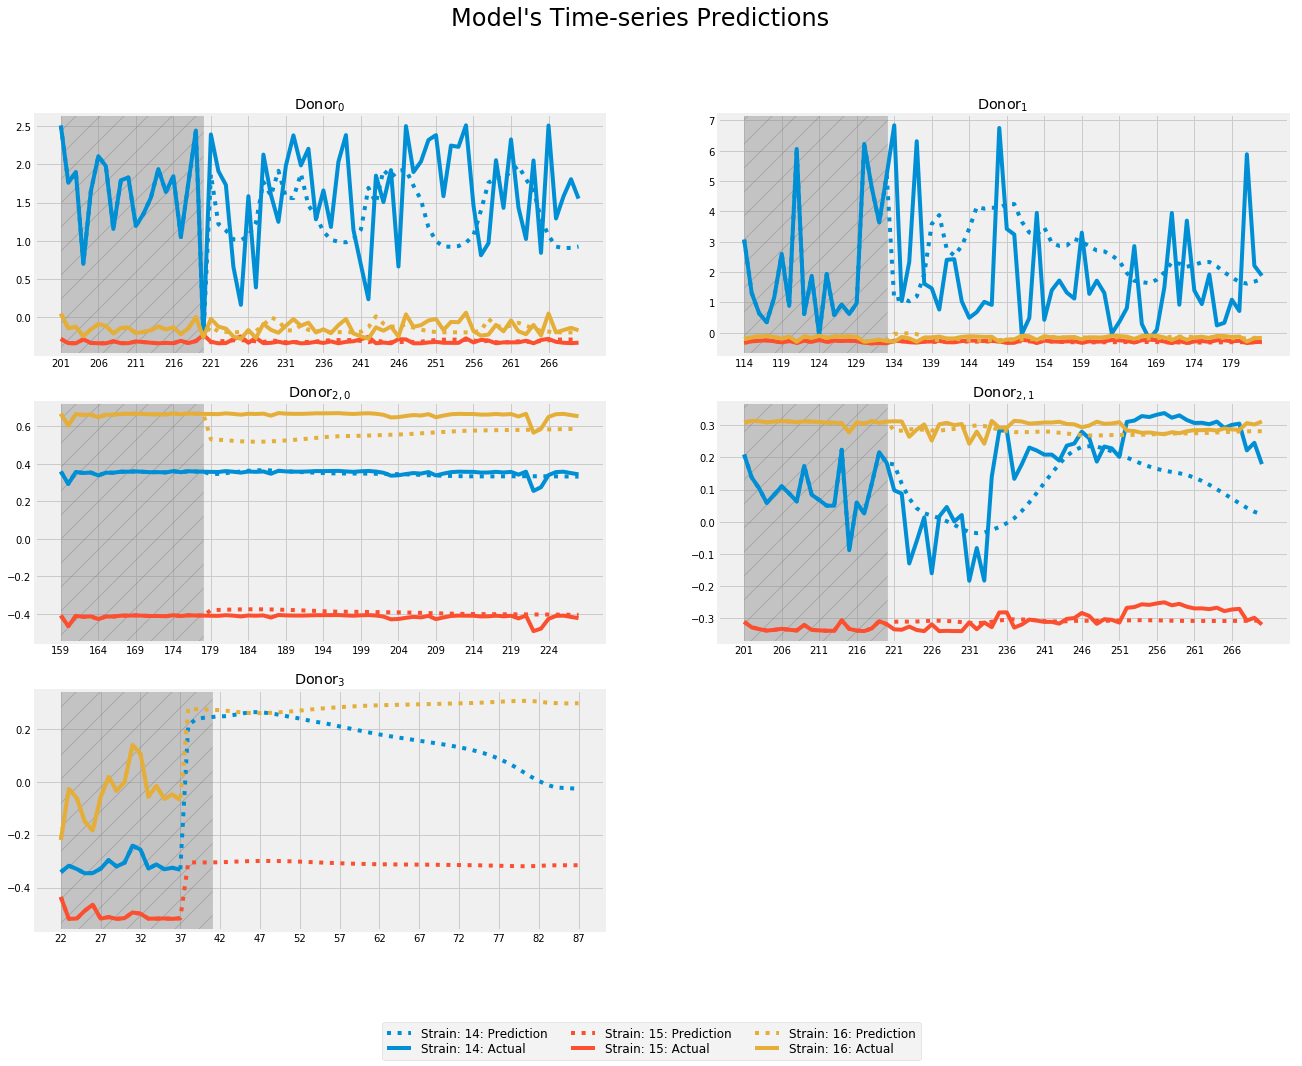

In [15]:
%matplotlib inline

# Generate subplots of the same data as above.
fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_width, subplot_height))
axl = ax.flatten()


# labels = ['Prediction', 'Actual']
for i, s in enumerate(otu_handler.samples):
    start_index = int(start_fraction * s.shape[1])
    primer, comparison = get_primer_and_comparison_data(otu_handler, 
                                                        i, 
                                                        start_index, 
                                                        primer_len, 
                                                        predict_length)
    dream = model.daydream(primer, predict_len=predict_length)
    
    if i == 0:
        for j, ri in enumerate(r):
            axl[i].plot(dream[ri, :, 0].T, ls=':', c=colors[j], label='{}: Prediction'.format(labels[j]))
            axl[i].plot(comparison[ri, :].T, c=colors[j], label='{}: Actual'.format(labels[j]))
    else:
        for j, ri in enumerate(r):
            axl[i].plot(dream[ri, :, 0].T, ls=':', c=colors[j], label='_nolegend_')
            axl[i].plot(comparison[ri, :].T, c=colors[j], label='_nolegend_')
    axl[i].axvspan(0, (primer_len) - 1, alpha=0.4, color='gray',
                label='_nolegend_', hatch='/')
    axl[i].set_xticks(list(range(primer_len + predict_length))[::5])
    axl[i].set_xticklabels(list(range(start_index, start_index + primer_len + predict_length))[::5])
    axl[i].set_title(file_labs[i])

# Cleanup
if num_rows * num_cols != len(otu_handler.samples):
    ax[-1, -1].axis('off')
    
fig.legend(loc='lower center', ncol=len(r), labelspacing=0.2, fontsize=12)
plt.suptitle('Model\'s Time-series Predictions', fontsize=24)
plt.show()
    

# Analysis of strain compression step.
Certain models have a step where the number of strains is compressed from `N` inputs to `M` outputs where `M < N`. Ideally this serves to give the LSTM an easier time.

In [16]:
# Extract the values from the network
compressor_vals = model.strain_compressor[0].weight.data.cpu().numpy()

In [17]:
# Do PCA on the data
pca = PCA(n_components=2)
pca.fit(compressor_vals.T)
trans = pca.transform(compressor_vals.T)
pca.explained_variance_ratio_

array([0.03074368, 0.02933463], dtype=float32)

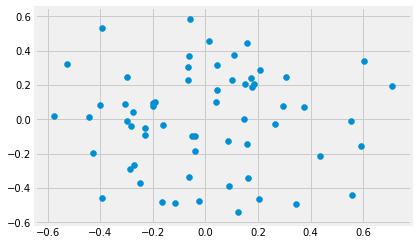

In [18]:
plt.scatter(trans[:, 0], trans[:, 1])

In [19]:
import pickle
import copy

In [20]:
# m2 = copy.deepcopy(model)
with open(r"my_trainer_object.pkl", "wb") as output_file:
    pickle.dump(model, output_file)